# Simple analysis of radar data

In [1]:
import os
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt

from loader import get_experiment_names, load_experiment

In [2]:
base_folder_path, names = get_experiment_names('SR250Mate', 'recovery')

for name in names:
    print(f"'{name}'")

'Millenial_M_recovery_20250526-180201_sr250_rx2.npy'
'Millenial_M_recovery_20250526-180201_sr250_rx1.npy'
'Millenial_M_recovery_20250526-180201_sr250_rx0.npy'


In [3]:
frames = load_experiment(base_folder_path, names[1])

For the SR250Mate sensor, `frames` is a 2D array of complex numbers. We take the magnitude of such numbers and plot the results.

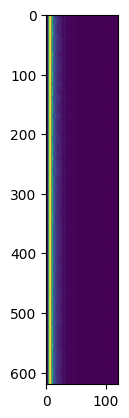

In [4]:
mag = np.abs(frames)

plt.imshow(mag)
plt.show()

There isn't the slightest difference between the rows of the data, which correspond to different time instants.

## Solution 1 - declutter
We perform the decluttering algorithm (but I'm not sure this is the correct name) to the data, as performed in `logger.py`

## Solution 2 - removing the mean
For each column we remove the mean and plot the data

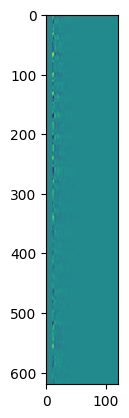

In [5]:
normalized = mag - np.mean(mag, axis=0)

plt.imshow(normalized)
plt.show()

This is much more promising, let's try some zooms

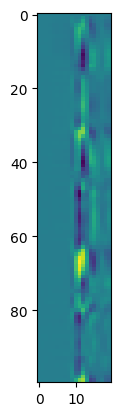

In [6]:
zoomed = normalized[:100, :20]

plt.imshow(zoomed)
plt.show()

There seems to be some regularity in the data. This is supposed to be Matteo standing in front of the sensor and breathing heavily. I want to analyze this data from a frequency perspective, but first I may combine all the bins into one. **REMARK**: some bins are not interesting.

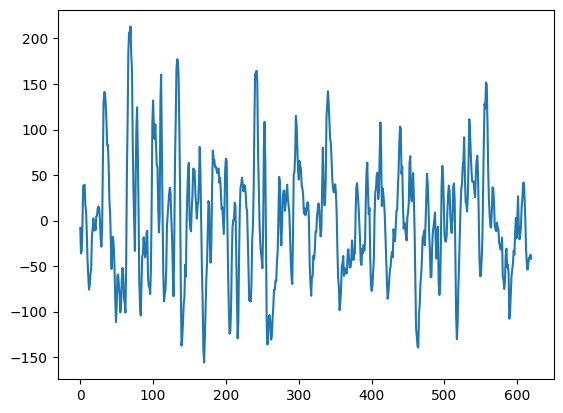

In [7]:
merged = np.mean(normalized[:,:20], axis=1)

plt.plot(merged)
plt.show()

This is very chaotic, but are there some regularities? Let's do a spectral analysis

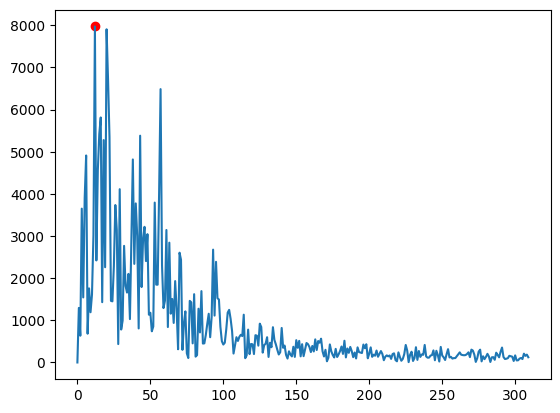

In [8]:
import scipy.fft


fhat = scipy.fft.fft(merged)
power = np.abs(fhat)[:(fhat.size//2)]

imax = np.argmax(power)

plt.plot(power)
plt.scatter(imax, power[imax], marker='o', c='r')
plt.show()

There seems to be a big peak in a non trivial spot. We need to find at what frequency it corresponds

In [9]:
samples_per_window = frames.shape[0]
samples_per_second = 20 # hardcoded from logger.py

seconds_per_window = samples_per_window / samples_per_second
print(f'{seconds_per_window}s')

31.0s


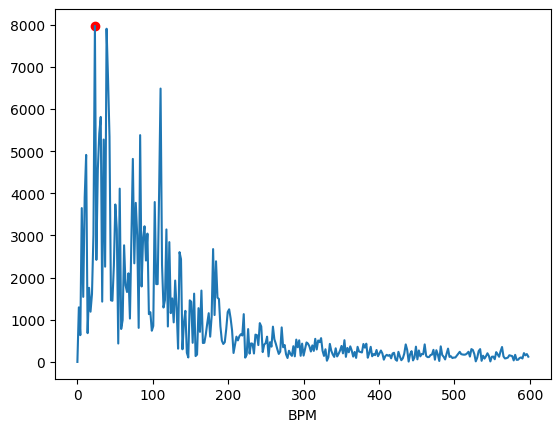

 0.387 Hz
 23.2 BPM


In [10]:
base_frequency = 1.0 / seconds_per_window
frequency_range_hz = np.arange(power.shape[0]) * base_frequency
frequency_range_bpm = 60 * frequency_range_hz

best_repeating_pattern_hz = frequency_range_hz[imax]
best_repeating_pattern_bpm = frequency_range_bpm[imax]

plt.plot(frequency_range_bpm, power)
plt.scatter(best_repeating_pattern_bpm, power[imax], c='r')
plt.xlabel('BPM')
plt.show()


print(f'{best_repeating_pattern_hz: .3f} Hz')
print(f'{best_repeating_pattern_bpm: .1f} BPM')

With a little bit of fantasy one could attribute this strong signal to the movement of the body **or to the breathing act**

In [11]:
# repeat the whole pipeline for every antenna of the signal

spectre = []

for name in names:
    frames = load_experiment(base_folder_path, name)

    mag = np.abs(frames)
    normalized = mag - np.mean(mag, axis=0)
    merged = np.mean(normalized[:,:20], axis=1)

    fhat = scipy.fft.fft(merged)
    power = np.abs(fhat)[:(fhat.size//2)]

    spectre.append(power)

spectre = np.array(spectre)
mean_spectre = np.mean(spectre, axis=0)

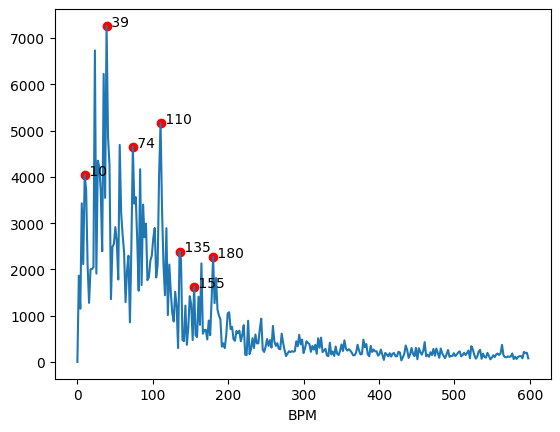

In [12]:
import scipy.signal
peaks = scipy.signal.find_peaks(mean_spectre, distance=10, threshold=1)[0]

plt.plot(frequency_range_bpm, mean_spectre)

for peak in peaks:
    if frequency_range_bpm[peak] < 200:
        plt.scatter(frequency_range_bpm[peak], mean_spectre[peak], c='r')
        plt.text(frequency_range_bpm[peak], mean_spectre[peak], f'{frequency_range_bpm[peak]: .0f}')

plt.xlabel('BPM')
plt.show()